**Object and Human Detection** <br>
<strong> Social Distancing Detection </strong>

STEPS : 
1. Object Detection using TensorFlow Object Detection API
2. Convert Video To Images
3. Visualize Objects in Image
4. Delete Boxes of other Objects except for Human
5. Visualize Humans
6. Calculate distance between Human Objects using Euler's distance formula between center points of both objects
7. Change color of human objects which are breaking rules of social distancing.
8. Visualize The Output Image
9. Convert Images to Video

**Functions**

1. load_model
2. run_inference_for_single_image
3. VideoToFrames
4. VisualizeImage
5. DisplayImage
6. FramesToVideo
7. getSingleHumanCoordinates
8. getDistance
9. VisualizeSocialDistancing
10. VisualizeHumanImage
11. FramesToStore
12. SocialDistanceToVideo


**Functions Explaination**:

1. **load_model** <br> 

    Args  : 
          model_name : Passing Tensorflow model Name
    Returns : Trained model

2. **run_inference_for_single_image** <br>

    Args : 
          model : Passing loaded Model
          image : Image to be processed
    
    Returns : 
              Output Dictionary which contains
              1. Detected Boxes Dimensions
              2. Detected Classes index 
                 eg [1,2,3] 1 is for Person
              3. Detected Scores which is 
                 list of scores for each detection
              4. Number of Detected Objects

3.  **VideoToFrames** <br>

    Args : 
          VideoFileName : Pass name of video file with ext 
          Path : Pass Path where to store Frames
    
    Returns:
            Creates Frames From video and store it in path

4.  **VisualizeImage**<br>
    
    Args: 
          ImageName : Pass name of Image to be Visualized
          Path : path to the image
    Returns:
            Image with object detected boxes drawn on it

5. **DisplayImage**<br>

    Args:
          Image : numpy array Image
    Output:
            Prints image to output

6. **FramesToVideo**<br>

    Args :
          no_of_frames : Number of frames to be converted to
                         Video
    Output :
            The Video with 15 fps created using 0-n frames

7. **getSingleHumanCoordinates**<br>
    Args :
          Boxes : List of Detected boxes coordinates
          Image : Image 
          position: position of object from list of 
                    coordinates
    Returns : 
            Left right bottom top coordinates of object

8. **getDistance**<br>
    Args :
          x1,x2,y1,y2 : Coordinates to find Distance
    Returns :
          Distance between (x1,y1) and (x2,y2)

9. **VisualizeSocialDistancing**<br>
    Args :
          Boxes : List of Coordinates of all objects
          Image : Image To Visualize
    Output :
          Draws red color on boxes near to each other

10. **VisualizeHumanImage**<br>
    Args :
          ImageName : Name of Image File to Visualize
          Path : path to Image
    Returns :
          Image with Boxes drawen

11. **FramesToStore**<br>
    Args : 
          tillFrame : Pass number of Frames to Visualize
    Output :
            Stores Visualized Image To SocialDistancingFrames
            Folder

12. **SocialDistanceToVideo**<br>
    Args :
          no_of_frames : Pass number of Frames
    Outputs :
            Video till no_of_frames of 15fps

In [0]:
import pandas as pd
import numpy as np
import pathlib
import cv2
from IPython.display import display

In [0]:
import tensorflow as tf

If using **Google Colab** UnComment Below Three Cells and Run Them 

If using **windows,linux,mac**<br>
Traverse to project path in cmd or Anaconda Prompt and run below steps

1. git clone --depth 1 https://github.com/tensorflow/models/
2. cd models/research/
3. protoc object_detection/protos/*.proto --python_out=.
4. pip install .

In [0]:
#if "models" in pathlib.Path.cwd().parts:
#    while "models" in pathlib.Path.cwd().parts:
#        os.chdir('..')
#elif not pathlib.Path('models').exists():
#    !git clone --depth 1 https://github.com/tensorflow/models/

In [0]:
#%%bash
#cd models/research/
#protoc object_detection/protos/*.proto --python_out=.

In [0]:
#%%bash 
#cd models/research
#pip install .

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
#Patches
utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

In [0]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
                                        fname=model_name, 
                                        origin=base_url + model_file,
                                        untar=True)
    
    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    model = model.signatures['serving_default']

    return model

In [0]:
model_name = 'faster_rcnn_inception_v2_coco_2018_01_28'
model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


**Get Object Positions and category** 

In [0]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    output_dict = model(input_tensor)

    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                     for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    if 'detection_masks' in output_dict:
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

Using Open CV converting **video** to **Frame**

In [0]:
def VideoToFrames(VideoFileName,path):
    VideoObj = cv2.VideoCapture(VideoFileName)
    currentframe = 0
    while(True): 
        success,frameImg = VideoObj.read() 

        if success: 

            name = './'+path+'/frame' + str(currentframe) + '.jpg'
            print ('Creating...' + name) 

            cv2.imwrite(name, frameImg) 

            currentframe += 1
        else: 
            break

    VideoObj.release() 
    cv2.destroyAllWindows() 

In [0]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

**From Position to Drawing boxes**

In [0]:
def VisualizeImage(ImageName,path):
    image = cv2.imread(path+'/'+ImageName+'.jpg')
    output_dict = run_inference_for_single_image(model, image)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=8)
    
    return image

In [0]:
def DisplayImage(image):
    display(Image.fromarray(image))

In [0]:
#VideoToFrames(VideoFileName='townCenter.avi',path='VideoFrames')

In [0]:
from PIL import Image

**Object Detection**

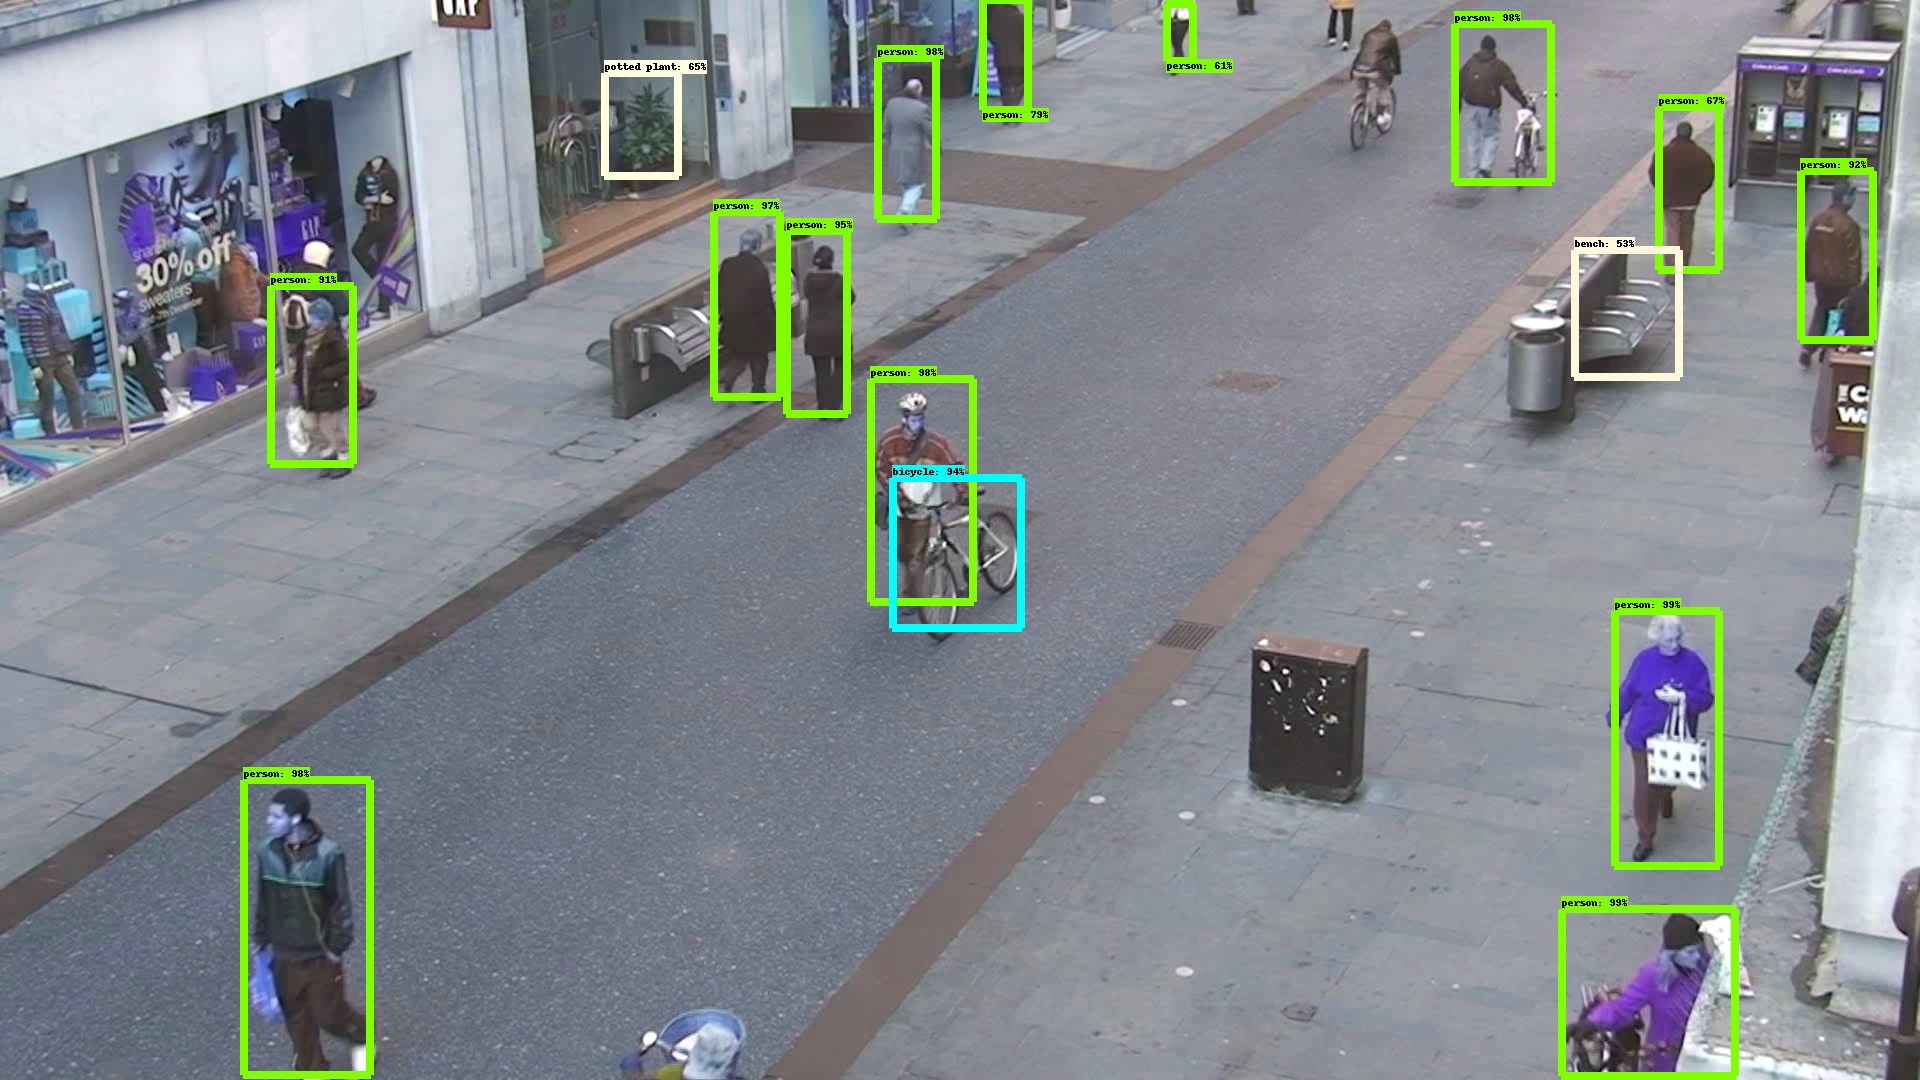

In [0]:
DisplayImage(VisualizeImage(ImageName = 'frame0' , path="VideoFrames"))

In [0]:
import os
from tqdm import tqdm

In [0]:
def FramesToVideo(no_of_frames):
    
    img_ar = []
    path, dirs, files = next(os.walk("VideoFrames"))
    file_count = len(files)
    if(no_of_frames < file_count):
        file_count = no_of_frames
    for i in tqdm(range(file_count)):
        img = VisualizeImage(ImageName = 'frame'+str(i) , path="VideoFrames")
        height, width, layers = img.shape
        size = (width,height)
        img_ar.append(img)
        
        
    out = cv2.VideoWriter('object_detection_'+str(no_of_frames)+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_ar)):
        out.write(img_ar[i])
    out.release()

In [0]:
#FramesToVideo(450)

In [0]:
image = cv2.imread('VideoFrames/frame12.jpg')
output_dict = run_inference_for_single_image(model, image)

In [0]:
output_dict

{'detection_boxes': array([[6.0476202e-01, 8.4340221e-01, 8.5785311e-01, 9.0227383e-01],
        [3.8509834e-01, 4.2586491e-01, 5.8261573e-01, 4.7963563e-01],
        [5.1377952e-02, 4.6603778e-01, 1.9456559e-01, 5.0144625e-01],
        [7.8761327e-01, 8.6127385e-02, 1.0000000e+00, 1.3792045e-01],
        [4.7760433e-01, 4.3142232e-01, 6.1284965e-01, 5.0829673e-01],
        [1.1427608e-02, 7.6575071e-01, 1.4987938e-01, 8.0861229e-01],
        [1.7827676e-01, 3.8808757e-01, 3.4675944e-01, 4.2326301e-01],
        [1.9737312e-01, 4.3497515e-01, 3.6674574e-01, 4.6194315e-01],
        [2.5004175e-01, 1.1018058e-01, 4.5613724e-01, 1.4768988e-01],
        [1.4739238e-01, 9.4856083e-01, 2.9755700e-01, 9.8275006e-01],
        [1.4265059e-01, 1.6490376e-01, 3.6314976e-01, 2.0625317e-01],
        [0.0000000e+00, 5.2041239e-01, 9.6626043e-02, 5.5203205e-01],
        [8.7784797e-01, 3.4977365e-01, 9.9991322e-01, 4.2384493e-01],
        [5.8930117e-04, 5.9820271e-01, 6.1189175e-02, 6.1227953e-01],
 

In [0]:
[ymin,xmin,ymax,xmax] = list(output_dict['detection_boxes'][0])

In [0]:
(left, right, top, bottom) = (xmin, xmax, ymin, ymax)

In [0]:
def getSingleHumanCoordinates(Boxes, Image, position):
  [ymin,xmin,ymax,xmax] = list(Boxes[position])
  im_height,im_width,im_channel = Image.shape
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
  
  return left,right,top,bottom

In [0]:
def getDistance(x1,x2,y1,y2):

  y_diff_sqr = (y2-y1)**2
  x_diff_sqr = (x2-x1)**2
  distance = (y_diff_sqr + x_diff_sqr)**0.5

  return distance

**if distance between 2 Images is less than 85 draw red boxes**

In [0]:
def VisualizeSocialDistancing(Boxes,Image):
  
  for i in range(len(Boxes)):
    
    left1,right1,top1,bottom1 = getSingleHumanCoordinates(Boxes,Image,i)
    (xCenter1,yCenter1) = (int((top1+bottom1)/2),int((left1+right1)/2))
    
    for j in range(len(Boxes)):
      
      if(i != j):
        left2,right2,top2,bottom2 = getSingleHumanCoordinates(Boxes,Image,j)
        (xCenter2,yCenter2) = (int((top2+bottom2)/2),int((left2+right2)/2))

        if(getDistance(xCenter1,xCenter2,yCenter1,yCenter2) <= 85):
          img = cv2.rectangle(Image,(int(left1),int(top1)),(int(right1),int(bottom1)),(0, 0, 255),4)
          img = cv2.rectangle(Image,(int(left2),int(top2)),(int(right2),int(bottom2)),(0, 0, 255),4)

**Visualizing Only Humans In Image**

In [0]:
def VisualizeHumansImage(ImageName,path):
    image = cv2.imread(path+'/'+ImageName+'.jpg')
    output_dict = run_inference_for_single_image(model, image)


    indexes_not_human = []
    for index in range(len(output_dict['detection_classes'])):
      if(output_dict['detection_classes'][index] != 1):
        indexes_not_human.append(index)

    
    a = np.array([])
    for i in range(len(output_dict['detection_boxes'])):
      if(i not in indexes_not_human):
        a = np.append(a,output_dict['detection_boxes'][i])


    n = len(a)
  
    detect_boxes = np.reshape(a,(int(n/4),4))

    VisualizeSocialDistancing(detect_boxes,image)

    vis_util.visualize_boxes_and_labels_on_image_array(
        image = image,
        boxes=detect_boxes,
        classes=np.array(np.delete(output_dict['detection_classes'],indexes_not_human)),
        scores=None,
        category_index=category_index,
        skip_scores = True,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=2,
        groundtruth_box_visualization_color='green')
    
    
    
    return image
    

Visualize Human Social **Distancing**

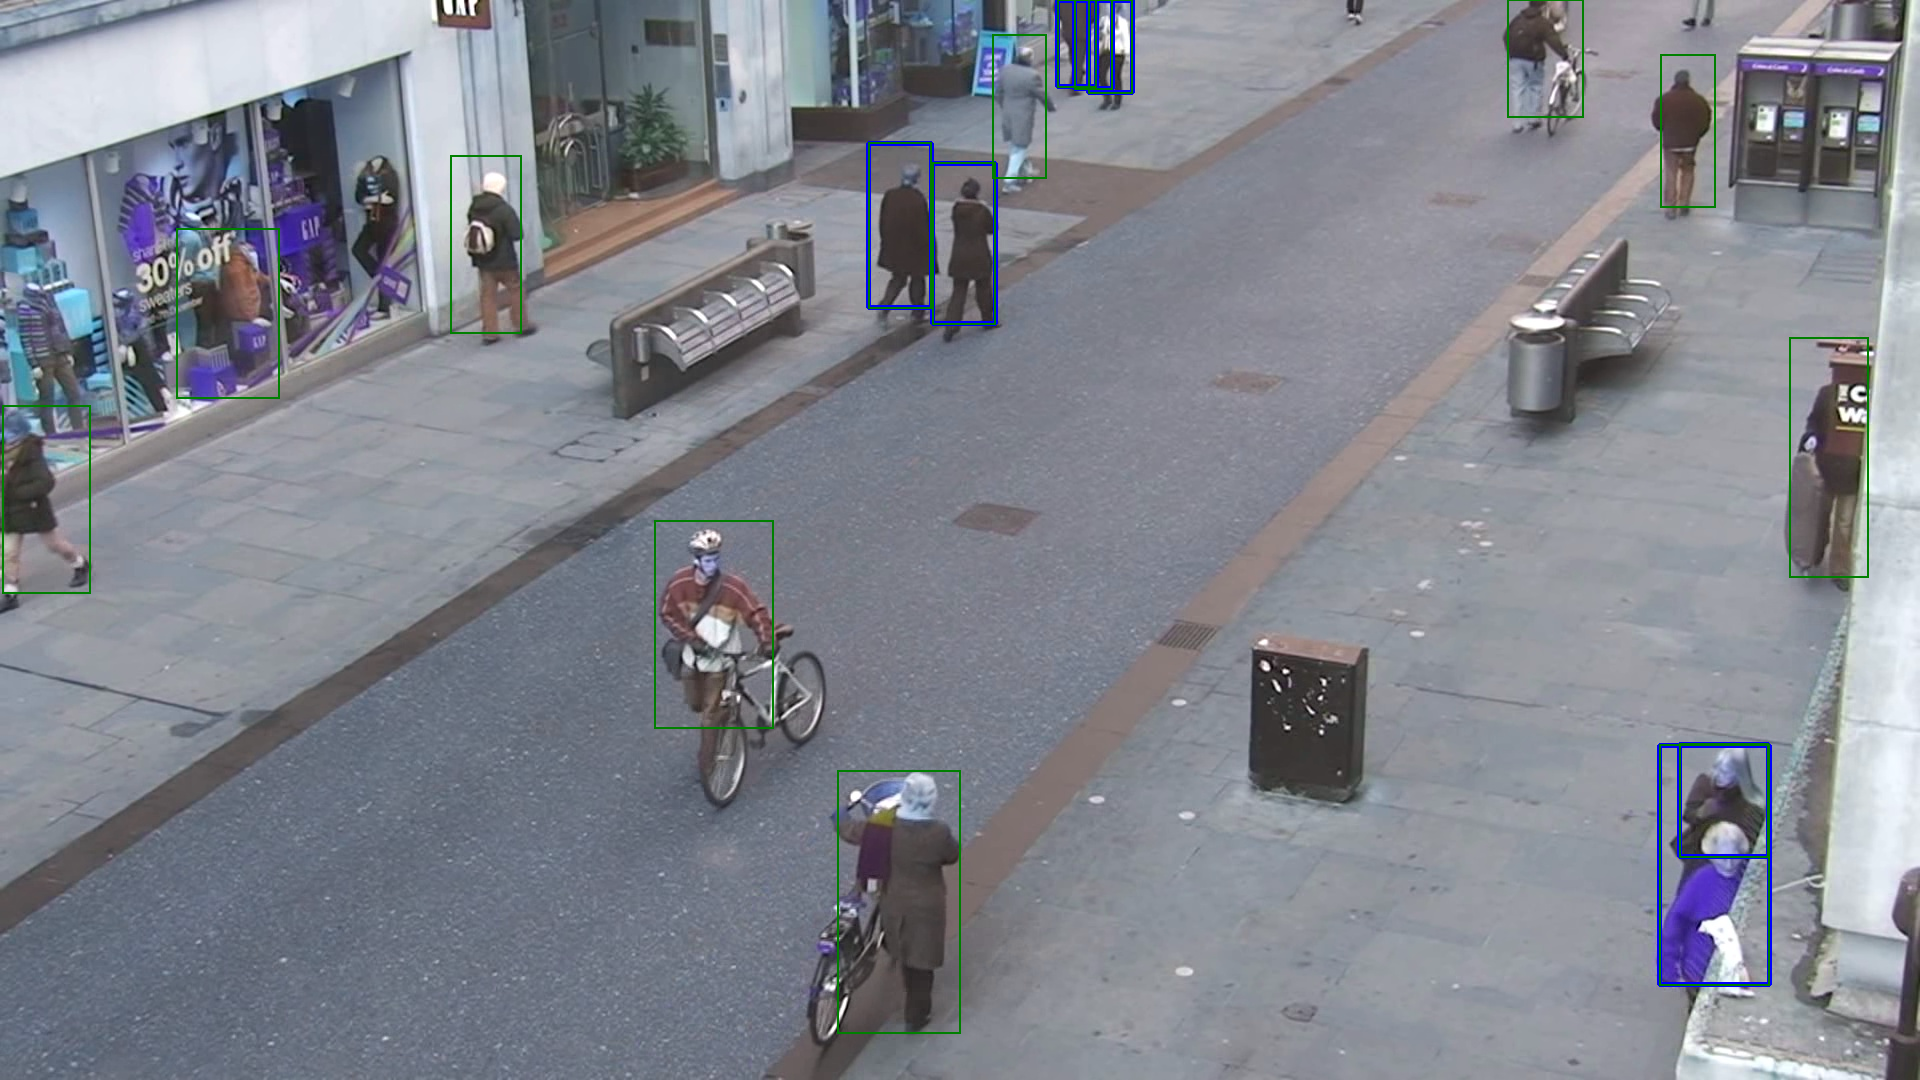

In [0]:
DisplayImage(VisualizeHumansImage(ImageName = 'frame50' , path="VideoFrames"))

**Saving Visualized Image To Folder SocialDistanceFrames**

In [0]:
def FramesToStore(tillFrame):

    path, dirs, files = next(os.walk("VideoFrames"))
    file_count = len(files)
    if(tillFrame > file_count):
      tillFrame = file_count
    for i in range(tillFrame):
      frameImg = VisualizeHumansImage(ImageName = 'frame'+str(i) , path="VideoFrames")
      name = './SocialDistanceFrames/frame' + str(i) + '.jpg'
      print ('Creating...' + name) 
      cv2.imwrite(name, frameImg)

In [0]:
FramesToStore(500)

Creating..../SocialDistanceFrames/frame0.jpg
Creating..../SocialDistanceFrames/frame1.jpg
Creating..../SocialDistanceFrames/frame2.jpg
Creating..../SocialDistanceFrames/frame3.jpg
Creating..../SocialDistanceFrames/frame4.jpg
Creating..../SocialDistanceFrames/frame5.jpg
Creating..../SocialDistanceFrames/frame6.jpg
Creating..../SocialDistanceFrames/frame7.jpg
Creating..../SocialDistanceFrames/frame8.jpg
Creating..../SocialDistanceFrames/frame9.jpg
Creating..../SocialDistanceFrames/frame10.jpg
Creating..../SocialDistanceFrames/frame11.jpg
Creating..../SocialDistanceFrames/frame12.jpg
Creating..../SocialDistanceFrames/frame13.jpg
Creating..../SocialDistanceFrames/frame14.jpg
Creating..../SocialDistanceFrames/frame15.jpg
Creating..../SocialDistanceFrames/frame16.jpg
Creating..../SocialDistanceFrames/frame17.jpg
Creating..../SocialDistanceFrames/frame18.jpg
Creating..../SocialDistanceFrames/frame19.jpg
Creating..../SocialDistanceFrames/frame20.jpg
Creating..../SocialDistanceFrames/frame21.jp

**Converting Frames to Video**

In [0]:
def SocialDistanceToVideo(no_of_frames):
    
    img_ar = []
    path, dirs, files = next(os.walk("SocialDistanceFrames"))
    file_count = len(files)
    if(no_of_frames < file_count):
        file_count = no_of_frames

    for i in tqdm(range(file_count)):
        img = cv2.imread( 'SocialDistanceFrames/frame'+str(i)+'.jpg' )
        img_ar.append(img)

    size = ( 1920   , 1080 )
    out = cv2.VideoWriter('Social_Distance_'+str(no_of_frames)+'.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    for i in range(len(img_ar)):
        out.write(img_ar[i])
    out.release()

In [0]:
SocialDistanceToVideo(450)





  5%|▌         | 24/450 [00:00<00:17, 23.96it/s]



  6%|▌         | 27/450 [00:01<00:18, 23.46it/s]



  7%|▋         | 30/450 [00:01<00:17, 23.65it/s]



  7%|▋         | 33/450 [00:01<00:17, 24.07it/s]



  8%|▊         | 36/450 [00:01<00:17, 24.12it/s]



  9%|▊         | 39/450 [00:01<00:17, 23.60it/s]



  9%|▉         | 42/450 [00:01<00:18, 22.66it/s]



 10%|█         | 45/450 [00:01<00:17, 22.66it/s]



 11%|█         | 48/450 [00:01<00:17, 22.34it/s]



 11%|█▏        | 51/450 [00:02<00:18, 22.07it/s]



 12%|█▏        | 54/450 [00:02<00:17, 22.15it/s]



 13%|█▎        | 57/450 [00:02<00:17, 22.73it/s]



 13%|█▎        | 60/450 [00:02<00:16, 23.37it/s]



 14%|█▍        | 63/450 [00:02<00:16, 23.95it/s]



 15%|█▍        | 66/450 [00:02<00:15, 24.18it/s]



 15%|█▌        | 69/450 [00:02<00:15, 24.13it/s]



 16%|█▌        | 72/450 [00:03<00:15, 23.84it/s]



 17%|█▋        | 75/450 [00:03<00:16, 23.11it/s]



 17%|█▋        | 78/450 [00:03<00:15, 23.77it/s]



 18%|█▊ 